In [1]:
# Importing Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import string
from nltk.stem import LancasterStemmer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
# Set path for Training data
data_path = r"/kaggle/input/movie-genre-classification/train_data.csv"
t_data = pd.read_csv(data_path, sep=':::', names=['Titles', 'Genres', 'Descriptions'], engine='python')

In [3]:
print(t_data.describe())

                                              Titles   Genres  \
count                                          54214    54214   
unique                                         54214       27   
top      Nature's Fury: Storm of the Century (2006)    drama    
freq                                               1    13613   

                                             Descriptions  
count                                               54214  
unique                                              54086  
top      Grammy - music award of the American academy ...  
freq                                                   12  


In [4]:
t_data.shape

(54214, 3)

In [5]:
# Load the test data
path_test = r"/kaggle/input/movie-genre-classification/test_data.txt"
test_data = pd.read_csv(path_test, sep=':::', names=['Ids', 'Titles', 'Descriptions'], engine='python')
test_data.head()

,Ids,Titles,Descriptions
0,1,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar..."
1,2,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch..."
2,3,Off the Beaten Track (2010),One year in the life of Albin and his family ...
3,4,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi..."
4,5,Er nu zhai (1955),Before he was known internationally as a mart...


In [6]:
#Count each genre value
t_data.Genres.value_counts()

Genres
drama           13613
documentary     13096
comedy           7447
short            5073
horror           2204
thriller         1591
action           1315
western          1032
reality-tv        884
family            784
adventure         775
music             731
romance           672
sci-fi            647
adult             590
crime             505
animation         498
sport             432
talk-show         391
fantasy           323
mystery           319
musical           277
biography         265
history           243
game-show         194
news              181
war               132
Name: count, dtype: int64

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26]),
 [Text(0, 0, ' drama '),
  Text(1, 0, ' documentary '),
  Text(2, 0, ' comedy '),
  Text(3, 0, ' short '),
  Text(4, 0, ' horror '),
  Text(5, 0, ' thriller '),
  Text(6, 0, ' action '),
  Text(7, 0, ' western '),
  Text(8, 0, ' reality-tv '),
  Text(9, 0, ' family '),
  Text(10, 0, ' adventure '),
  Text(11, 0, ' music '),
  Text(12, 0, ' romance '),
  Text(13, 0, ' sci-fi '),
  Text(14, 0, ' adult '),
  Text(15, 0, ' crime '),
  Text(16, 0, ' animation '),
  Text(17, 0, ' sport '),
  Text(18, 0, ' talk-show '),
  Text(19, 0, ' fantasy '),
  Text(20, 0, ' mystery '),
  Text(21, 0, ' musical '),
  Text(22, 0, ' biography '),
  Text(23, 0, ' history '),
  Text(24, 0, ' game-show '),
  Text(25, 0, ' news '),
  Text(26, 0, ' war ')])

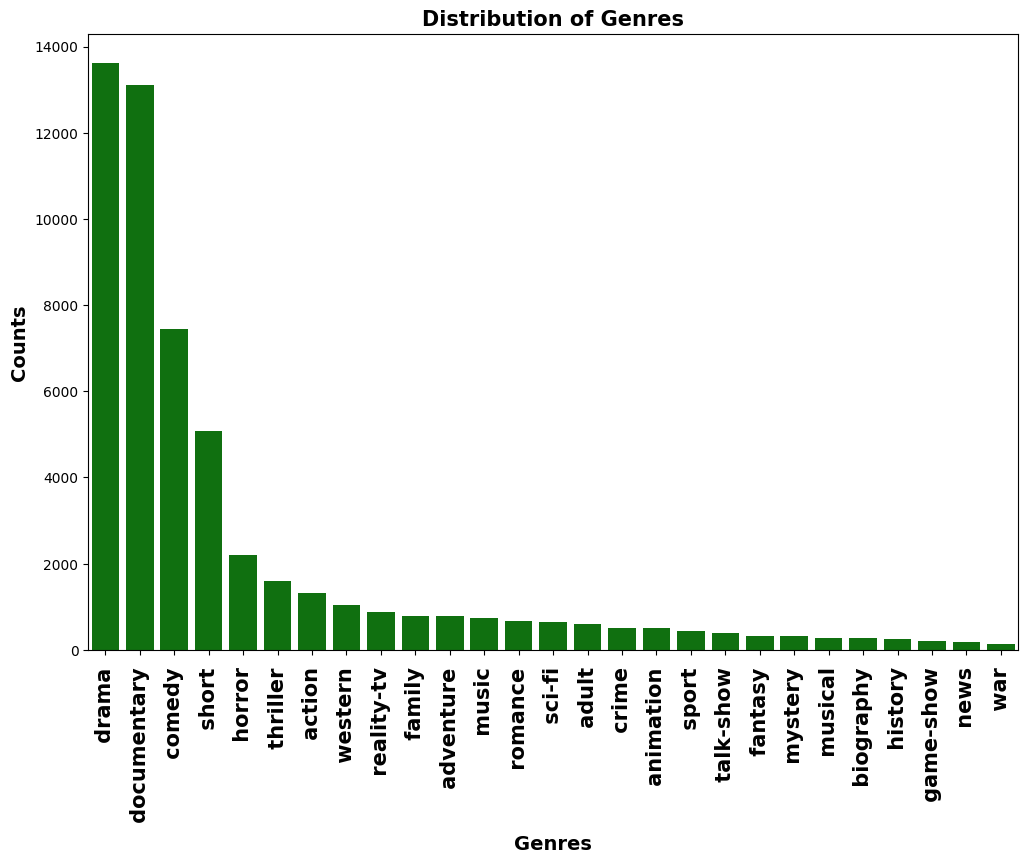

In [7]:
# Count plot
plt.figure(figsize=(12,8))
count = t_data.Genres.value_counts()
sns.barplot(x=count.index, y=count, color='green')
plt.xlabel('Genres' ,fontsize=14, fontweight='bold')
plt.ylabel('Counts', fontsize=14, fontweight='bold')
plt.title('Distribution of Genres', fontsize=15, fontweight='bold')
plt.xticks(rotation=90, fontsize=15, fontweight='bold')


In [8]:
t_data.info()
#Find any null values
t_data.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
Index: 54214 entries, "1  to "54214 
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Titles        54214 non-null  object
 1   Genres        54214 non-null  object
 2   Descriptions  54214 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


Titles          0
Genres          0
Descriptions    0
dtype: int64

In [9]:
# Initialize the stemmer and stop words
stemmer = LancasterStemmer()
nltk.download('punkt')

# Define the clean_text function
def clean_text(text):
    text = text.lower()  # Lowercase all characters
    text = re.sub(r'@\S+', '', text)  # Removes Twitter handles
    text = re.sub(r'http\S+', '', text)  # Removes URLs
    text = re.sub(r'pic.\S+', '', text)
    text = re.sub(r"[^a-zA-Z+']", ' ', text)  # Keeps only characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text + ' ')  # Keeps words with length > 1 only
    text = "".join([i for i in text if i not in string.punctuation])
    words = nltk.word_tokenize(text)
    stopwords = nltk.corpus.stopwords.words('english')  # Removes stopwords
    text = " ".join([i for i in words if i not in stopwords and len(i) > 2])
    text = re.sub(r"\s+", " ", text).strip()  # Removes repeated/leading/trailing spaces
    return text

# Apply the clean_text function to the 'Description' column in the training and test data
t_data['Text_cleaning'] = t_data['Descriptions'].apply(clean_text)
test_data['Text_cleaning'] = test_data['Descriptions'].apply(clean_text)

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


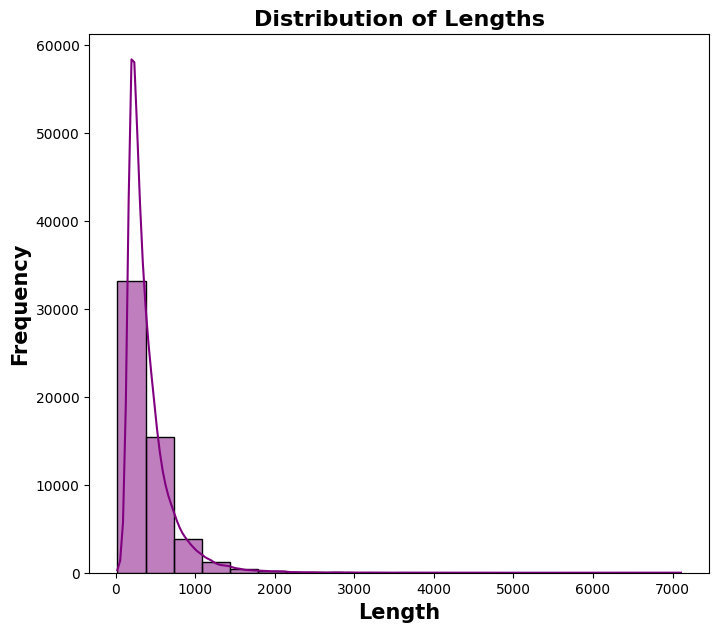

In [10]:
t_data['length_Text_cleaning'] = t_data['Text_cleaning'].apply(len)
# Visualize the distribution of text lengths
plt.figure(figsize=(8, 7))
sns.histplot(data=t_data, x='length_Text_cleaning', bins=20, kde=True, color='purple')
plt.xlabel('Length', fontsize=15, fontweight='bold')
plt.ylabel('Frequency', fontsize=15, fontweight='bold')
plt.title('Distribution of Lengths', fontsize=16, fontweight='bold')
plt.show()

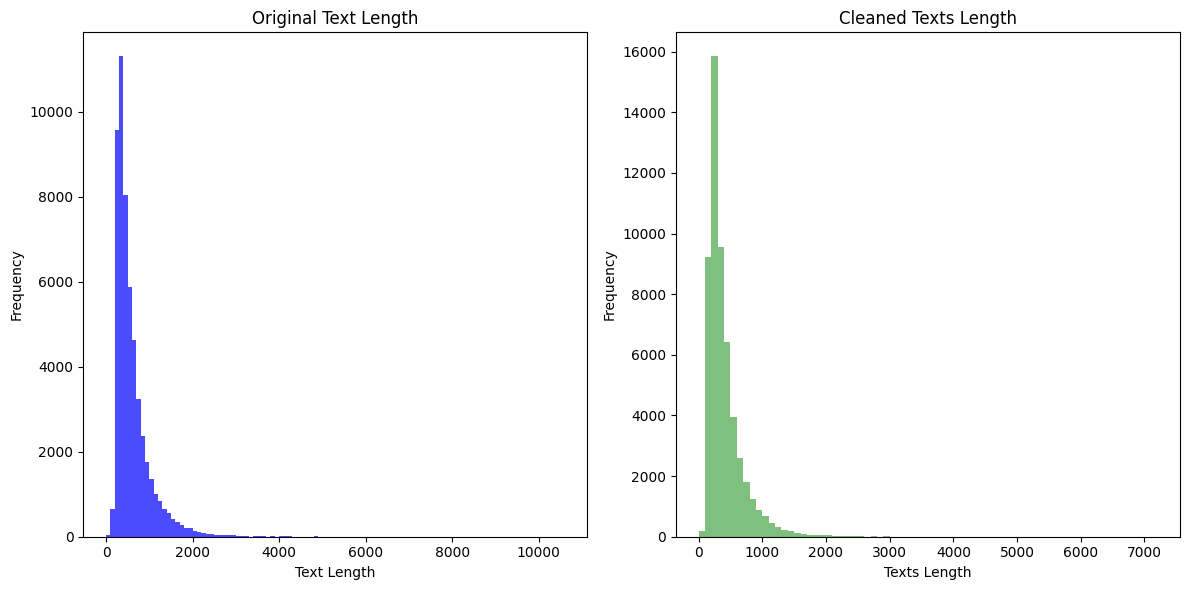

In [12]:
# Set up the figures with two subplots
plt.figure(figsize=(12, 6))

# Subplot 1: Original texts length distribution
plt.subplot(1, 2, 1)
original_lengths = t_data['Descriptions'].apply(len)
plt.hist(original_lengths, bins=range(0, max(original_lengths) + 100, 100), color='blue', alpha=0.7)
plt.title('Original Text Length')
plt.xlabel('Text Length')
plt.ylabel('Frequency')

# Cleaned texts length distribution
plt.subplot(1, 2, 2)
cleaned_lengths = t_data['Text_cleaning'].apply(len)
plt.hist(cleaned_lengths, bins=range(0, max(cleaned_lengths) + 100, 100), color='green', alpha=0.5)
plt.title('Cleaned Texts Length')
plt.xlabel('Texts Length')
plt.ylabel('Frequency')

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

In [13]:
t_data.shape

(54214, 5)

In [14]:
test_data

,Ids,Titles,Descriptions,Text_cleaning
0,1,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar...",brane loves life car apartment job especially ...
1,2,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch...",spain march quico naughty child three belongin...
2,3,Off the Beaten Track (2010),One year in the life of Albin and his family ...,one year life albin family shepherds north tra...
3,4,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi...",father died hasnt spoken brother years serious...
4,5,Er nu zhai (1955),Before he was known internationally as a mart...,known internationally martial arts superstar b...
...,...,...,...,...
54195,54196,"""Tales of Light & Dark"" (2013)","Covering multiple genres, Tales of Light & Da...",covering multiple genres tales light dark anth...
54196,54197,Der letzte Mohikaner (1965),As Alice and Cora Munro attempt to find their...,alice cora munro attempt find father british o...
54197,54198,Oliver Twink (2007),A movie 169 years in the making. Oliver Twist...,movie years making oliver twist artful dodger ...
54198,54199,Slipstream (1973),"Popular, but mysterious rock D.J Mike Mallard...",popular mysterious rock mike mallard askew bro...


In [16]:
X = t_data['Titles'] + ' ' + t_data['Text_cleaning']  # Assuming 'Text_cleaning' contains preprocessed text data
y = t_data['Genres']

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=True)

# Initialize TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.9)

# Fit and transform the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Transform the validation data
X_val_tfidf = tfidf_vectorizer.transform(X_val)

from sklearn.svm import SVC

# Initialize and train a Support Vector Machine classifier
svm_classifier = SVC(kernel='linear',cache_size=400)  # You can choose different kernels such as 'linear', 'rbf', etc.
svm_classifier.fit(X_train_tfidf, y_train)

# Make predictions on the validation set
y_pred_svm = svm_classifier.predict(X_val_tfidf)

# Evaluate the performance of the Support Vector Machine model
accuracy_svm = accuracy_score(y_val, y_pred_svm)
print("Validation Accuracy (Support Vector Machine):", accuracy_svm)
print(classification_report(y_val, y_pred_svm, zero_division=1))



Validation Accuracy (Support Vector Machine): 0.6052752928156414
               precision    recall  f1-score   support

      action        0.52      0.35      0.42       263
       adult        0.77      0.44      0.56       112
   adventure        0.49      0.22      0.30       139
   animation        0.64      0.13      0.22       104
   biography        1.00      0.00      0.00        61
      comedy        0.55      0.61      0.58      1443
       crime        0.18      0.02      0.03       107
 documentary        0.68      0.85      0.76      2659
       drama        0.56      0.78      0.65      2697
      family        0.41      0.10      0.16       150
     fantasy        0.57      0.05      0.10        74
   game-show        0.88      0.53      0.66        40
     history        1.00      0.00      0.00        45
      horror        0.69      0.67      0.68       431
       music        0.65      0.52      0.58       144
     musical        0.67      0.04      0.08        50

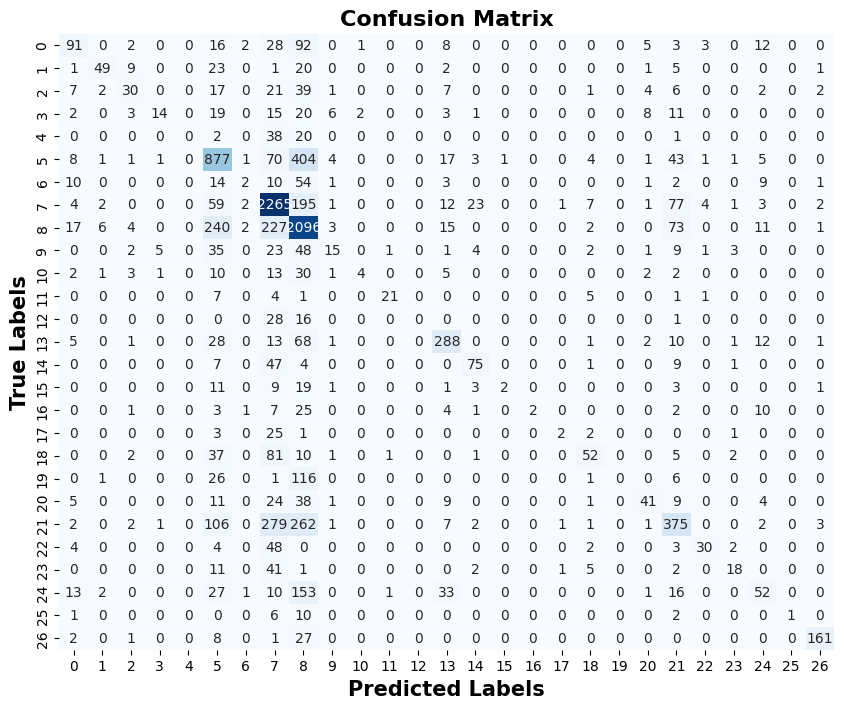

In [18]:
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred_svm)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels', fontsize=15, fontweight='bold')
plt.ylabel('True Labels', fontsize=15, fontweight='bold')
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.show()
